In [14]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
import keras
from random import seed
from random import randint
from keras.models import load_model
import imageio

## Create the full dataset by running `data_aug.py` (located in `scripts/` folder) on the initial dataset of 100 images

## Choose your input mode; can be either a loaded file or a new file, obtained via webcam. 

In the box below:
+ Set `mode` = `'test'` to iterate through the test set (4800 images) 
+ Set `mode` = `</path/to/file>` to upload a new file
+ Set `mode` = `'cam'` to record a new video using your webcam 
    + NOTICE: Forward-facing webcam will turn on!
    + Press `Esc` or Restart the kernel to turn it off
    + The classification is only performed on the middle of the webcam display, size (224,224)
    + The classification makes the camera run _very_ slow; comment out the lines indicated in `bb_webcam()` to only draw bounding boxes and restore the frame rate
    

In [30]:
mode = 'test' 
path_to_data = './data/test'

If you chose `test` for the mode, the model will run predictions first on the entire dataset and report its accuracy. 

Individual input files will be processed and a prediction will be generated (Coke bottle `present` or `not present`); additionally, a bounding box will be drawn around the coke bottles. 

For `test` mode, 10 randomly sampled examples are processed. 

In [16]:
def full_eval(tst_data):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False, 
                                               weights='imagenet')
    top1 = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(1, activation='sigmoid')
                                ])
    top2 = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(1, activation='sigmoid')
                                ])
    top3 = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(1, activation='sigmoid')
                                ])
#     top.set_weights('./model/mobilenetv2.h5')
    top1.set_weights('./model/mnv2_wts.h5')
    model1 = tf.keras.Sequential([base_model,
                                 top1
                                ])
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     top2.set_weights('./model/mobilenetv2_wts.h5')
#     model2 = tf.keras.Sequential([base_model,
#                                  top2
#                                 ])
#     model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
    
#     top3.set_weights('./model/resnet50_weights.h5')
#     model3 = tf.keras.Sequential([base_model,
#                                  top3
#                                 ])
#     model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
    

#     base_model = tf.keras.applications.ResNet50(input_shape=224,
#                                                     include_top=True,
#                                                     weights='imagenet')
    
#     model = tf.keras.Sequential([
#       base_model,
#       tf.keras.layers.GlobalAveragePooling2D(),
#       tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model.set_weights('./model/resnet50_weights.h5')
#     model=load_model('./mnv2_model.h5')

    test_generator.reset()
    preds1 = model1.predict_generator(tst_data,verbose=1)
#     test_generator.reset()
#     preds2 = model2.predict_generator(tst_data,verbose=1)
#     test_generator.reset()
#     preds3 = model3.predict_generator(tst_data,verbose=1)
#     scores = model.evaluate(tst_data, labs)
    
    return preds1#,preds2,preds3

In [17]:
def predx(f,fileio=True):
    """ Runs predictions on single examples """
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False, 
                                               weights='imagenet')
    top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(1, activation='sigmoid')
                                ])
    top.set_weights('./model/mnv2_wts.h5')
    model = tf.keras.Sequential([base_model,
                                 top
                                ])
    if fileio: 
        f = image.load_img(f, target_size=(224,224))
        f = image.img_to_array(f)
    x = np.expand_dims(f,axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    return pred

In [18]:
def bb_file(img, filei=True):
    """ Draws a bounding box on the input image, if a bounding box is predicted """
    if filei: imag = cv2.imread(img)
    gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
    # Detect coke bottle in the image
    coke_cascade = cv2.CascadeClassifier('./opencascade/cascade.xml')
    cokes = coke_cascade.detectMultiScale(gray, 60, 60)
    print(cokes)
    if len(cokes)>0: print("Found a coke bottle!")

    # Draw a rectangle around the faces
    for (x, y, w, h) in cokes:
        cv2.rectangle(imag, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(np.flip(imag))
    plt.show()
    # cv2.waitKey(0)

#### Comment out the lines between the green lines to speed up the frame rate (but lose some classification accuracy)

In [19]:
def bb_webcam():
    """ Opens the webcam and performs inference on the video stream """
    coke_cascade = cv2.CascadeClassifier('./opencascade/cascade.xml')

    cap = cv2.VideoCapture(0)

    while 1:
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        ret, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cokes = coke_cascade.detectMultiScale(gray, 60, 60)
        #----------COMMENT BETWEEN THESE LINES IF DESIRED-------------#
        p = predx(img[128:128+224,208:208+224,:], fileio=False)
        if p >= 0.5: print(f"Predicted a Coke bottle is PRESENT with {p[0][0]*100:.2f}% certainty.")
        else: print(f"Predicted a Coke bottle is NOT PRESENT with {(1-p[0][0])*100:.2f}% certainty.")
        #----------COMMENT BETWEEN THESE LINES IF DESIRED-------------#
        for (x,y,w,h) in cokes:
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img,'Coke',(x-w,y-h), 0.5, (0,255,255), 2, cv2.LINE_AA)
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)

        cv2.imshow('img',img)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

#### Generate the standard test est

In [20]:
test=[]
for i in os.listdir(f'{path_to_data}/test/ims/coke/'):
    if i.endswith('png'):
        test.append([f'{path_to_data}/test/ims/coke/'+i,1])
for i in os.listdir(f'{path_to_data}/test/ims/not_coke/'):
    if i.endswith('png'):
        test.append([f'{path_to_data}/test/ims/not_coke/'+i,0])
np.random.shuffle(test)
tst_ims = np.array([np.array(imageio.imread(im[0])) for im in test])
tst_lab = [im[1] for im in test]

### Only run the step below if you want to get the overall performance on the entire testing set. It takes a while to run! 
+ Tests 3 different weigth configurations (if all uncommented in `full_eval()`
+ The accuracies tend to vary ... highest obtained acc was ~70% using mnv2_wts.h5

In [26]:
if mode=='test':
    
#     labels={0:'not_coke',1:'coke'}
#     print(f"Labels: {labels}")
    
#     validation_dir = os.path.join(path_to_data, 'validation','ims')
#     validation_not_dir = os.path.join(validation_dir,'not_coke')
#     validation_coke_dir = os.path.join(validation_dir,'coke')
#     validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#     validation_generator = validation_datagen.flow_from_directory(
#                     validation_dir,target_size=(224, 224),
#                     batch_size=32,class_mode='binary')
    
    test_dir = os.path.join(path_to_data,'test','ims')
    test_not_dir = os.path.join(test_dir,'not_coke')
    test_coke_dir = os.path.join(test_dir,'coke')
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
                        test_dir,target_size=(224, 224),
                        batch_size=1,class_mode=None, shuffle=False,
                        seed=42)
    filenames=test_generator.filenames
    p1=full_eval(test_generator)


Found 2400 images belonging to 2 classes.
Found 4800 images belonging to 2 classes.
4800/4800 [==============================] - 337s 70ms/step


#### Get the models' performance on the entire test set

In [27]:
ax=[]
labels={0:'coke',1:'not_coke'}
# for p in [p1,p2,p3]:
count=0
for i in range(len(p1)):
    if labels[(round(p1[i][0]))] == filenames[i].split('/')[0]:
        count+=1
acc = count/len(p1)
ax.append(acc)
print(np.max(ax))

0.5747916666666667



+----------------------------------------+

| Overall accuracy on testing set: 57.48% |

+----------------------------------------+
'
Predicted a Coke bottle is PRESENT with 73.22% certainty.
()


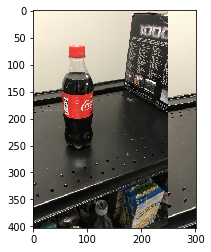

Predicted a Coke bottle is NOT PRESENT with 52.84% certainty.
()


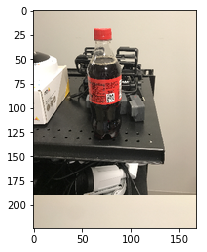

Predicted a Coke bottle is PRESENT with 80.55% certainty.
()


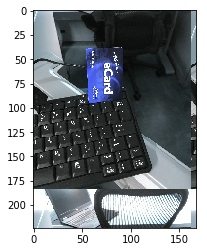

Predicted a Coke bottle is NOT PRESENT with 80.35% certainty.
()


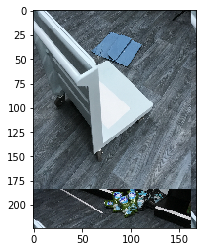

Predicted a Coke bottle is NOT PRESENT with 88.13% certainty.
()


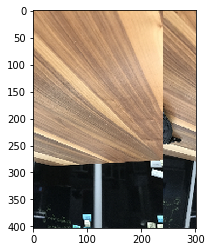

Predicted a Coke bottle is NOT PRESENT with 77.22% certainty.
[[141 276  50  50]]
Found a coke bottle!


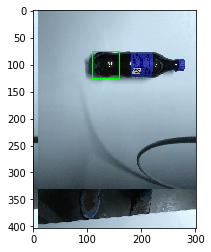

Predicted a Coke bottle is NOT PRESENT with 67.62% certainty.
()


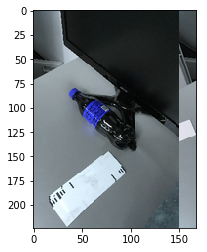

Predicted a Coke bottle is NOT PRESENT with 87.28% certainty.
()


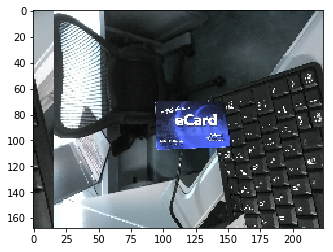

Predicted a Coke bottle is PRESENT with 56.70% certainty.
()


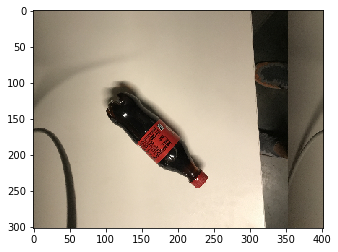

Predicted a Coke bottle is PRESENT with 51.00% certainty.
()


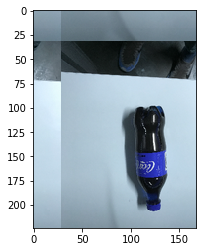

In [28]:
if mode=='test':
    print("\n+----------------------------------------+\n")
    print(f"| Overall accuracy on testing set: {np.max(ax)*100:.2f}% |\n")
    print("+----------------------------------------+\n'")

    seed(1)
    indx=[]
    for _ in range(10):
        indx.append(randint(0,len(test)))
    for im in indx:
        pred = predx(test[im][0])
        if pred >= 0.5: print(f"Predicted a Coke bottle is PRESENT with {pred[0][0]*100:.2f}% certainty.")
        else: print(f"Predicted a Coke bottle is NOT PRESENT with {(1-pred[0][0])*100:.2f}% certainty.")
        bb_file(test[im][0])
elif mode == 'cam': 
    bb_webcam()
else:
    pred=predx(mode)
    if pred >= 0.5: print(f"Predicted a Coke bottle is PRESENT with {pred[0][0]*100:.2f}% certainty.")
    else: print(f"Predicted a Coke bottle is NOT PRESENT with {(1-pred[0][0])*100:.2f}% certainty.")
    bb_file(mode)